<a href="https://colab.research.google.com/github/jacquesbilombe/Payment-Patterns-Brazil/blob/main/Payment_Patterns_Brazil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Fetching and Saving (Extraction)

As mentioned at the project README.md, the proeject data is a public one, which can be find at [Kaggle](https://www.kaggle.com/datasets/clovisdalmolinvieira/brazilian-payment-methods).

![picture](https://drive.google.com/uc?export=view&id=12UFZ9lt2h-u_eYBqmkNoJuNtz2Z_m-xJ)

After finding the data needed for this project, it was downloaded locally before to be uploaded into a Google Clouud Storage Bucket. As the dataset, the bucket was setted without any restriction, meaning it's public; allowing anyone with the access to this Google Colab to run or download it without Google Authentification.

### GCP - Bucket

Following the steps from Google documentation or watching this official Google Tech video, anyone can create a bucket for their project:

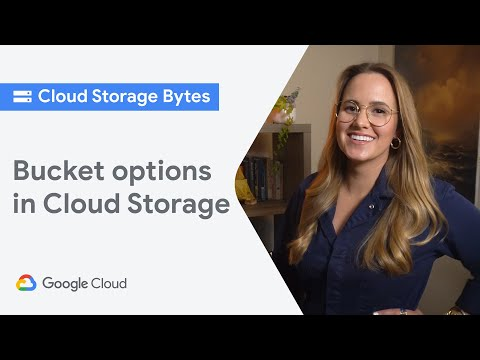

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('8DMOJ6Lgm7s', width=980, height=500)

The dataset was uploaded manually into the bucket:

![picture](https://drive.google.com/uc?export=view&id=1H7tOAzK7VC-uyl_Hk_2ftXfhM31V88yF)

## Data Transformation


### Data exploration and cleaning


In [1]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.cloud import storage

In [2]:
url = 'https://storage.googleapis.com/payment-patterns-brazil/brazilian_payment_methods.csv'
# Download the file (Public Access)
response = requests.get(url)

# Save the file locally
file_path = '/content/brazilian_payment_methods.csv'
with open(file_path, 'wb') as file:
    file.write(response.content)

# Read the CSV file
df = pd.read_csv(file_path)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   YearMonth                       101 non-null    int64  
 1   quantityPix                     101 non-null    float64
 2   valuePix                        101 non-null    float64
 3   quantityTED                     101 non-null    float64
 4   valueTED                        101 non-null    float64
 5   quantityTEC                     101 non-null    float64
 6   valueTEC                        101 non-null    float64
 7   quantityBankCheck               101 non-null    float64
 8   valueBankCheck                  101 non-null    float64
 9   quantityBrazilianBoletoPayment  101 non-null    float64
 10  valueBrazilianBoletoPayment     101 non-null    float64
 11  quantityDOC                     101 non-null    float64
 12  valueDOC                        101 

By looking  at the dataset, the colunms with "Quantity" of the transaction by payment method are identified as `Float` which doesn't make sense. In real world, there aren't 1.5 money transfer. As the result, all float of these columns will be rounded down (turn into integers).

In [4]:
def round_down(df):
  df['quantityPix'] = df['quantityPix'].astype('int32')
  df['quantityTED'] = df['quantityTED'].astype('int32')
  df['quantityTEC'] = df['quantityTEC'].astype('int32')
  df['quantityBankCheck'] = df['quantityBankCheck'].astype('int32')
  df['quantityBrazilianBoletoPayment'] = df['quantityBrazilianBoletoPayment'].astype('int32')
  df['quantityDOC'] = df['quantityDOC'].astype('int32')
  return df

df = round_down(df)
df.head()

,YearMonth,quantityPix,valuePix,quantityTED,valueTED,quantityTEC,valueTEC,quantityBankCheck,valueBankCheck,quantityBrazilianBoletoPayment,valueBrazilianBoletoPayment,quantityDOC,valueDOC
0,202405,5228826,2137205.79,69023,3482036.97,0,0.00,10467,40133.55,349180,506302.82,0,0.00
1,202404,4924681,2083746.68,70647,3652606.48,0,0.00,11179,43295.40,361633,524619.69,0,0.00
2,202403,4903392,1936188.21,67565,3333054.27,0,0.00,10122,36644.55,336435,469047.59,0,0.00
3,202402,4367133,1718217.65,65805,2981226.45,60,109.32,10373,37076.26,332269,463066.01,61,34.21
4,202401,4371541,1818473.97,70343,3337344.85,387,815.94,11919,41615.89,363550,516702.44,600,616.58


In [5]:
# List of columns to check for zero values
columns_to_check = ['quantityTEC', 'quantityDOC','quantityPix','quantityTED',
                    'quantityBankCheck','quantityBrazilianBoletoPayment','quantityDOC']

# Excluding rows where any of the specified columns have zero value
df = df[(df[columns_to_check] != 0).all(axis=1)]
df.head()

,YearMonth,quantityPix,valuePix,quantityTED,valueTED,quantityTEC,valueTEC,quantityBankCheck,valueBankCheck,quantityBrazilianBoletoPayment,valueBrazilianBoletoPayment,quantityDOC,valueDOC
3,202402,4367133,1718217.65,65805,2981226.45,60,109.32,10373,37076.26,332269,463066.01,61,34.21
4,202401,4371541,1818473.97,70343,3337344.85,387,815.94,11919,41615.89,363550,516702.44,600,616.58
5,202312,4804459,1933836.67,80202,3629758.88,1152,2498.31,11241,39208.22,337552,484391.91,1412,1399.42
6,202311,4231283,1740874.02,74398,3135994.81,754,1711.45,11866,40735.16,345234,490503.75,1506,1521.77
7,202310,4069683,1666062.39,71870,3325168.12,664,1578.12,12902,46646.90,362721,512336.66,1746,1763.79


In [6]:
def summary_data(df, head=5):
    func = {
        "Info": df.info(),
        "Shape": df.shape,
        "Null": df.isnull().sum(),
        "Describe": df.describe().T
    }

    for n, f in func.items():
        print("\n################### ", n, " ###################\n")
        if isinstance(f, pd.DataFrame) or isinstance(f, pd.Series):
            print(f)
        else:
            print(f)

summary_data(df)

<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 3 to 42
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   YearMonth                       40 non-null     int64  
 1   quantityPix                     40 non-null     int32  
 2   valuePix                        40 non-null     float64
 3   quantityTED                     40 non-null     int32  
 4   valueTED                        40 non-null     float64
 5   quantityTEC                     40 non-null     int32  
 6   valueTEC                        40 non-null     float64
 7   quantityBankCheck               40 non-null     int32  
 8   valueBankCheck                  40 non-null     float64
 9   quantityBrazilianBoletoPayment  40 non-null     int32  
 10  valueBrazilianBoletoPayment     40 non-null     float64
 11  quantityDOC                     40 non-null     int32  
 12  valueDOC                        40 non-null

### Data Catalog

To archieve our goal in this part of the project, we'll follow these steps:
- Create dataset time dimension
- Minimum and Maximum Expected Values ​​for Numeric Data
- Description of Tables and Columns
- Categories for Categorical Data

In [7]:
# Create the time dimension dataframe
df['Year'] = df['YearMonth'].astype(str).str[:4].astype(int)
df['Month'] = df['YearMonth'].astype(str).str[4:].astype(int)

dim_time = df[['YearMonth', 'Year', 'Month']].drop_duplicates().reset_index(drop=True)
dim_time['TimeKey'] = dim_time.index + 1

# Create the fact table
fact_transactions = df.copy()

<ipython-input-7-337938bc823a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['YearMonth'].astype(str).str[:4].astype(int)
<ipython-input-7-337938bc823a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month'] = df['YearMonth'].astype(str).str[4:].astype(int)


In [8]:
# Merge with dim_time to get the TimeKey
fact_transactions = fact_transactions.merge(dim_time, on='YearMonth', how='left')

# Select relevant columns for fact table
fact_transactions = fact_transactions[['YearMonth','TimeKey', 'quantityPix', 'valuePix', 'quantityTED',
                                       'valueTED', 'quantityTEC', 'valueTEC', 'quantityBankCheck',
                                       'valueBankCheck', 'quantityBrazilianBoletoPayment',
                                       'valueBrazilianBoletoPayment', 'quantityDOC', 'valueDOC']]
fact_transactions.head()

,YearMonth,TimeKey,quantityPix,valuePix,quantityTED,valueTED,quantityTEC,valueTEC,quantityBankCheck,valueBankCheck,quantityBrazilianBoletoPayment,valueBrazilianBoletoPayment,quantityDOC,valueDOC
0,202402,1,4367133,1718217.65,65805,2981226.45,60,109.32,10373,37076.26,332269,463066.01,61,34.21
1,202401,2,4371541,1818473.97,70343,3337344.85,387,815.94,11919,41615.89,363550,516702.44,600,616.58
2,202312,3,4804459,1933836.67,80202,3629758.88,1152,2498.31,11241,39208.22,337552,484391.91,1412,1399.42
3,202311,4,4231283,1740874.02,74398,3135994.81,754,1711.45,11866,40735.16,345234,490503.75,1506,1521.77
4,202310,5,4069683,1666062.39,71870,3325168.12,664,1578.12,12902,46646.90,362721,512336.66,1746,1763.79


In [9]:
tb_payment = fact_transactions.copy()

def min_max(df):

  cols = df.columns
  min_max_df = pd.DataFrame(columns=["min", "max"])

  for col in cols:
      min_value = df[col].min()
      max_value = df[col].max()
      min_max_df.loc[col] = [min_value, max_value]

  return min_max_df

min_max_df = min_max(tb_payment)
min_max_df.reset_index(inplace=True)
min_max_df.rename(columns={"index": "column"}, inplace=True)

# min_max_df into dict
min_max_dict = min_max_df.set_index('column').to_dict()


In [10]:
# Definir as columns do catálogo de dados
catalog_columns = ['Column', 'Description', 'Type', 'Min', 'Max', 'Categories']

# Criar uma lista de dicionários com as informações de cada column
catalog_data = [
    {'column': 'TimeKey', 'Description': 'Primary key, unique identifier of time', 'Type': 'Integer', 'Min': 1, 'Max': 'n', 'Categories': None},
    {'column': 'YearMonth', 'Description': 'Reference month and year in YYYYMM format', 'Type': 'Integer', 'Min': 201001, 'Max': 202312, 'Categories': None},
    {'column': 'quantityPix', 'Description': 'Number of PIX transactions', 'Type': 'Integer', 'Min': 0, 'Max': 'to be calculated', 'Categories': None},
    {'column': 'valuePix', 'Description': 'Total value of PIX transactions', 'Type': 'Float', 'Min': 0.0, 'Max': 'to be calculated', 'Categories': None},
    {'column': 'quantityTED', 'Description': 'Number of TED transactions', 'Type': 'Integer', 'Min': 0, 'Max': 'to be calculated', 'Categories': None},
    {'column': 'valueTED', 'Description': 'Total value of TED transactions', 'Type': 'Float', 'Min': 0.0, 'Max': 'to be calculated', 'Categories': None},
    {'column': 'quantityTEC', 'Description': 'Number of TEC transactions', 'Type': 'Integer', 'Min': 0, 'Max': 'to be calculated', 'Categories': None},
    {'column': 'valueTEC', 'Description': 'Total value of TEC transactions', 'Type': 'Float', 'Min': 0.0, 'Max': 'to be calculated', 'Categories': None},
    {'column': 'quantityBankCheck', 'Description': 'Number of bank checks', 'Type': 'Integer', 'Min': 0, 'Max': 'to be calculated', 'Categories': None},
    {'column': 'valueBankCheck', 'Description': 'Total value of bank checks', 'Type': 'Float', 'Min': 0.0, 'Max': 'to be calculated', 'Categories': None},
    {'column': 'quantityBrazilianBoletoPayment', 'Description': 'Number of boleto payments', 'Type': 'Integer', 'Min': 0, 'Max': 'to be calculated', 'Categories': None},
    {'column': 'valueBrazilianBoletoPayment', 'Description': 'Total value of boleto payments', 'Type': 'Float', 'Min': 0.0, 'Max': 'to be calculated', 'Categories': None},
    {'column': 'quantityDOC', 'Description': 'Number of DOC transactions', 'Type': 'Integer', 'Min': 0, 'Max': 'to be calculated', 'Categories': None},
    {'column': 'valueDOC', 'Description': 'Total value of DOC transactions', 'Type': 'Float', 'Min': 0.0, 'Max': 'to be calculated', 'Categories': None},
]


# Associate the dict min_max_dict with dict list catalog_data
for i in range(len(catalog_data)):
  column_name = catalog_data[i]['column']
  catalog_data[i]['Min'] = min_max_dict['min'][column_name]
  catalog_data[i]['Max'] = min_max_dict['max'][column_name]

# Criar um DataFrame a partir da lista de dicionários
catalog_df = pd.DataFrame(catalog_data)
catalog_df

,column,Description,Type,Min,Max,Categories
0,TimeKey,"Primary key, unique identifier of time",Integer,1.00,40.00,None
1,YearMonth,Reference month and year in YYYYMM format,Integer,202011.00,202402.00,None
2,quantityPix,Number of PIX transactions,Integer,32867.00,4804459.00,None
3,valuePix,Total value of PIX transactions,Float,29196.99,1933836.67,None
4,quantityTED,Number of TED transactions,Integer,65805.00,191703.00,None
5,valueTED,Total value of TED transactions,Float,2381021.03,3810324.55,None
6,quantityTEC,Number of TEC transactions,Integer,60.00,1305.00,None
7,valueTEC,Total value of TEC transactions,Float,109.32,2757.91,None
8,quantityBankCheck,Number of bank checks,Integer,10373.00,22020.00,None
9,valueBankCheck,Total value of bank checks,Float,37076.26,58871.56,None


### Analysis

In this section, we'll try to answer all five questions made about this dataset previously:

- How has the adoption of different payment methods evolved?
- What are the most and least popular payment methods?
- How do the total values of transactions compare across different payment methods?
- Are there seasonal or monthly trends in using these payment methods?

`Obs:` fact_transactions dataframe will be used as it has the entire dimension of the project.

#### 1. Evolution of payment methods adoption

In [11]:
df = fact_transactions.copy()
# Convert YearMonth to datetime
df['YearMonth'] = pd.to_datetime(df['YearMonth'], format='%Y%m')

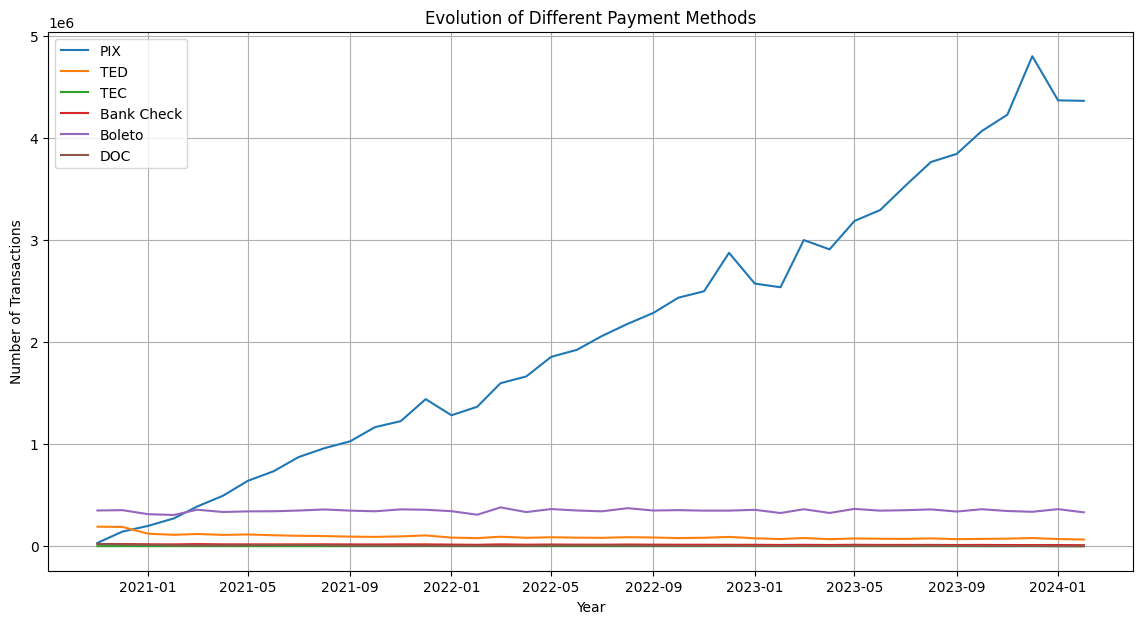

In [12]:
# Plot a linear chart telling the history of the payment method
plt.figure(figsize=(14, 7))
plt.plot(df['YearMonth'], df['quantityPix'], label='PIX')
plt.plot(df['YearMonth'], df['quantityTED'], label='TED')
plt.plot(df['YearMonth'], df['quantityTEC'], label='TEC')
plt.plot(df['YearMonth'], df['quantityBankCheck'], label='Bank Check')
plt.plot(df['YearMonth'], df['quantityBrazilianBoletoPayment'], label='Boleto')
plt.plot(df['YearMonth'], df['quantityDOC'], label='DOC')

plt.xlabel('Year')
plt.ylabel('Number of Transactions')
plt.title('Evolution of Different Payment Methods')
plt.legend()
plt.grid(True)
plt.show()

Overtime, some payment methods remained constant such as Boleto, TEC, Bank Check; on the other hand the use of `Pix` as payment method gained popularity and becoming the prefer among people.

#### 2. Most and least popular payment methods

In [13]:
# Sum the quantity of transactions for each payment method
total_transactions = {
    'PIX': df['quantityPix'].sum(),
    'TED': df['quantityTED'].sum(),
    'TEC': df['quantityTEC'].sum(),
    'Bank Check': df['quantityBankCheck'].sum(),
    'Boleto': df['quantityBrazilianBoletoPayment'].sum(),
    'DOC': df['quantityDOC'].sum()
}

# Convert to DataFrame
total_transactions_df = pd.DataFrame(list(total_transactions.items()),
                                     columns=['Payment Method', 'Total Transactions'])


In [14]:
# Sort by total transactions
total_transactions_df = total_transactions_df.sort_values(by='Total Transactions',
                                                          ascending=False)

total_transactions_df.head()

,Payment Method,Total Transactions
0,PIX,84153246
4,Boleto,13906453
1,TED,3709651
3,Bank Check,628580
5,DOC,238667


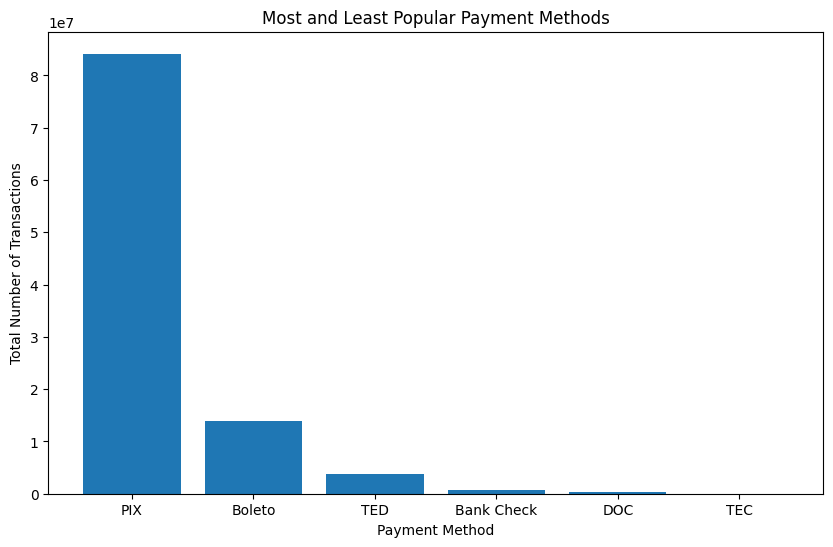

In [15]:
# Plot
plt.figure(figsize=(10, 6))
plt.bar(total_transactions_df['Payment Method'], total_transactions_df['Total Transactions'])
plt.xlabel('Payment Method')
plt.ylabel('Total Number of Transactions')
plt.title('Most and Least Popular Payment Methods')
plt.show()

#### 3. Comparison of total values of transactions across different payment methods

In [16]:
# Sum the value of transactions for each payment method
total_values = {
    'PIX': df['valuePix'].sum(),
    'TED': df['valueTED'].sum(),
    'TEC': df['valueTEC'].sum(),
    'Bank Check': df['valueBankCheck'].sum(),
    'Boleto': df['valueBrazilianBoletoPayment'].sum(),
    'DOC': df['valueDOC'].sum()
}

In [17]:
total_values_df = pd.DataFrame(list(total_values.items()),
                               columns=['Payment Method', 'Total Values (R$)'])

# Sort by total values
total_values_df = total_values_df.sort_values(by='Total Values (R$)',
                                              ascending=False)

total_values_df.head()

,Payment Method,Total Values (R$)
1,TED,1.287558e+08
0,PIX,3.696107e+07
4,Boleto,1.781962e+07
3,Bank Check,1.981300e+06
5,DOC,1.967023e+05


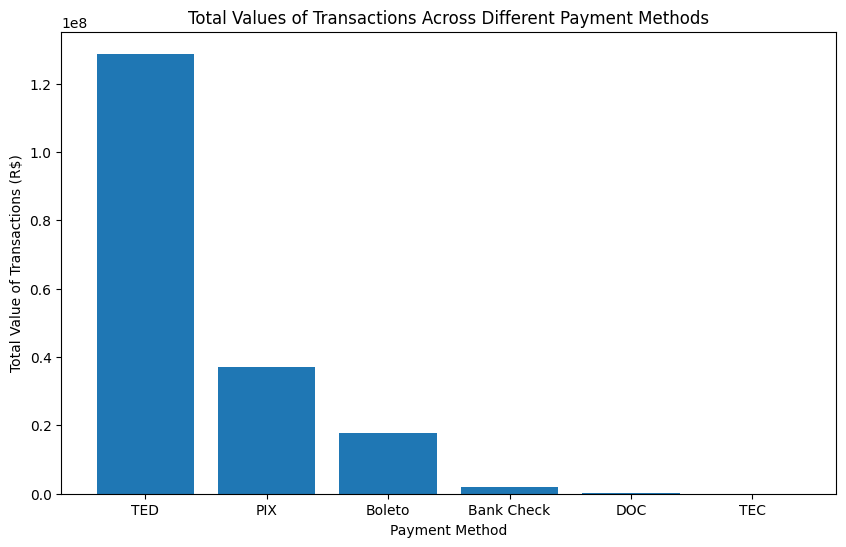

In [18]:
# Plot
plt.figure(figsize=(10, 6))
plt.bar(total_values_df['Payment Method'], total_values_df['Total Values (R$)'])
plt.xlabel('Payment Method')
plt.ylabel('Total Value of Transactions (R$)')
plt.title('Total Values of Transactions Across Different Payment Methods')
plt.show()

By combining the first and second chart, we can see that the method `PIX` is the popular one, however, it just started to be used near 2021, meaning its transaction record is very recent. where `TED` is an old method which it continues to be used to transfer money.

#### 4. Seasonal or monthly trends in using these payment methods

In [19]:
# Extract month and year from YearMonth
df['Month'] = df['YearMonth'].dt.month
df['Year'] = df['YearMonth'].dt.year

# Select only numeric columns before grouping
numeric_df = df.select_dtypes(include=['number'])

In [20]:
# Group by month and sum the transactions
monthly_trends = numeric_df.groupby('Month').sum().reset_index()

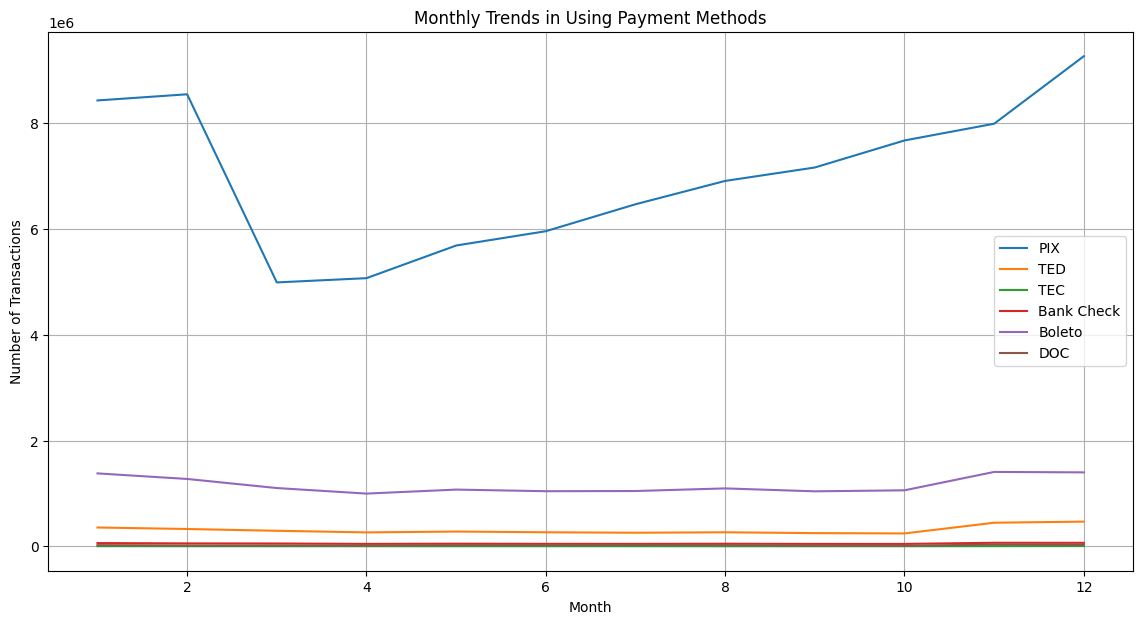

In [21]:
# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(x='Month', y='quantityPix', data=monthly_trends, label='PIX')
sns.lineplot(x='Month', y='quantityTED', data=monthly_trends, label='TED')
sns.lineplot(x='Month', y='quantityTEC', data=monthly_trends, label='TEC')
sns.lineplot(x='Month', y='quantityBankCheck', data=monthly_trends, label='Bank Check')
sns.lineplot(x='Month', y='quantityBrazilianBoletoPayment', data=monthly_trends, label='Boleto')
sns.lineplot(x='Month', y='quantityDOC', data=monthly_trends, label='DOC')

plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.title('Monthly Trends in Using Payment Methods')
plt.legend()
plt.grid(True)
plt.show()

The payment methods that suffer significant fluctuation during a year are:
- PIX: between Febuary and March, for Bank or simular institute it might be a good insight or warning to try to understand the cause of the fluctuation.
- Boleto: the number of transaction litely descreaded in the same period as PIX, however, there isn't a pull back until December.
- Other Methods: in general the number of transactions is constant during the entire year.

## Data Storage (Load)

In this section, we'll upload the transformed dataset into our bucket and after that, a BigQuery will be created to storage the data to be used.

We'll start by creating a new Folder to store the transformed data into the bucket
![picture](https://drive.google.com/uc?export=view&id=1-ownbofch-xL6SKJSTrYc8ZvpAClfkeT)


[gsutil](https://cloud.google.com/storage/docs/gsutil) is used for the upload; it is a Python application that lets you access Cloud Storage from the command line. You can use gsutil to do a wide range of bucket and object management tasks, including:

- Creating and deleting buckets.
- Uploading, downloading, and deleting objects.
- Listing buckets and objects.
- Moving, copying, and renaming objects.
- Editing object and bucket ACLs.

gsutil performs all operations, including uploads and downloads, using HTTPS and transport-layer security (TLS).


###### 1º: Upload the transformed Data

In [33]:
!gsutil version

gsutil version: 5.30


In [22]:
fact_transactions.head()

,YearMonth,TimeKey,quantityPix,valuePix,quantityTED,valueTED,quantityTEC,valueTEC,quantityBankCheck,valueBankCheck,quantityBrazilianBoletoPayment,valueBrazilianBoletoPayment,quantityDOC,valueDOC
0,202402,1,4367133,1718217.65,65805,2981226.45,60,109.32,10373,37076.26,332269,463066.01,61,34.21
1,202401,2,4371541,1818473.97,70343,3337344.85,387,815.94,11919,41615.89,363550,516702.44,600,616.58
2,202312,3,4804459,1933836.67,80202,3629758.88,1152,2498.31,11241,39208.22,337552,484391.91,1412,1399.42
3,202311,4,4231283,1740874.02,74398,3135994.81,754,1711.45,11866,40735.16,345234,490503.75,1506,1521.77
4,202310,5,4069683,1666062.39,71870,3325168.12,664,1578.12,12902,46646.90,362721,512336.66,1746,1763.79


In [29]:
# Save the dataset
transformed_file_path = '/content/transformed.csv'
fact_transactions.to_csv(transformed_file_path, index=False)


In [30]:
# Storage config
bucket_name = 'base_payment/transformed_data/'

!gsutil cp {transformed_file_path} gs://{bucket_name}
!gsutil ls gs://{bucket_name}


Copying file:///content/transformed.csv [Content-Type=text/csv]...
-
Operation completed over 1 objects/4.2 KiB.                                      
gs://base_payment/transformed_data/
gs://base_payment/transformed_data/transformed.csv


![picture](https://drive.google.com/uc?export=view&id=1V8FhDVI3pdTcpauAjGqr3vj3jJSyqJ9W)


##### BigQuery (Data Warehouse)

This section is divided in 4 parts:
- 1: Create of the Dataset
- 2: Add transformed data into a table
- 3: Implementation of the schema
- 4: Verification and data consult

###### 1º: Create BigQuery


Everything was seted as default, except the dataset name:


![picture](https://drive.google.com/uc?export=view&id=1XxSv99b6PyQbIzv3OPQ2MbovaA3ASRIU)


###### 2º: Add transformed data into a table

This table fetches the .csv file from our bucket by selecting "Google Cloud Storage" as the table source. Morever, we used JSON schema to help the Bigquery to understand the structure of the table.

![picture](https://drive.google.com/uc?export=view&id=1FsxHAY1zS8wL0mAysSaBlgGmPkmfpQuT)


###### 3º: Implementation of the schema

It was decided to apply a Star Schema using the uploaded data as raw. which result into two dataset, one whith the `Transaction information` and the other with `Date and Time`information.

- Dimension Table:

```sql
CREATE OR REPLACE TABLE `Dataset_Payment.dim_time`
(
  YearMonth INT64 OPTIONS(description="The reference month in YYYYMM format"),
  Year INT64 OPTIONS(description="The year extracted from YearMonth"),
  Month INT64 OPTIONS(description="The month extracted from YearMonth")
)
AS
SELECT
  YearMonth,
  EXTRACT(YEAR FROM PARSE_DATE('%Y%m', CAST(YearMonth AS STRING))) AS Year,
  EXTRACT(MONTH FROM PARSE_DATE('%Y%m', CAST(YearMonth AS STRING))) AS Month
FROM
  `Dataset_Payment.tb_transformed`
GROUP BY
  YearMonth;

```

![picture](https://drive.google.com/uc?export=view&id=1SHWcbM2V_58TqZKHVtfGgVth8vHlKD-N)

Dimension Table:

![picture](https://drive.google.com/uc?export=view&id=1OgyzMWxTN9ti4mldywKRbP5Mt2mYbLyT)

###### 4º: Verification and data consult